In [1]:
from matplotlib import pyplot as plt
import missingno as msno 
import numpy as np
import pandas as pd
from scipy.stats import probplot
import seaborn as sns
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, make_scorer, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

--------------------

# Data exploration
**Aim:** "Cleanse the data and prepare it to be suitable for statistical modelling and machine learning. Comment on the steps performed and explain the rationale for them."

## Summary

Descriptive statistics and frequency distributions are computed for all variables during data exploration & cleansing. Key observations and actions are outlined below.

1. Erroneous Data
   
    * No duplicate rows are identified.
      
    * All occurrences of 'PROMO34' in the ‘credit_score’ column are replaced with a missing value.
  
2. Distributions

    * A relatively uniform distribution is observed for age.
      
    * ‘Savings_bal_lbg’ exhibits a positive skew.
      
    * The ‘childcare_spend’ and ‘gambling_spend’ columns contain a high proportion of zeros (94.6% and 90.8%, respectively). Omitting zero values in the ‘childcare_spend’ column reveals a symmetric distribution, while omitting zero values in the ‘gambling_spend’ column reveals a positive skew.
      
    * A high proportion of zeros is present in the 'annual_net_savings_lbg' feature, which displays an otherwise symmetric distribution.
  
3. Missing values

    * Missing values are present in the ‘other_income’ (13.9%), ‘housing_spend’ (24.2%), and ‘credit_score’ (3.5%) columns. A total of 1,362 rows contain more than one missing value.
      
    * Random forests are trained to predict the presence of a missing value in the 'other_income' and 'housing_spend' columns using observed values in other features. This suggests these missing values are not missing completely at random. No meaningful prediction was achieved for missing 'credit_score' values; therefore, these missing values may be missing at random.
      
    * Missing values in the ‘other_income’ and ‘housing_income’ columns are imputed via regression using a random forest.
      
    * Missing values in the ‘credit_score’ column are dropped, as these missing values appear to occur completely at random, and their removal is unlikely to introduce significant bias.
  
4. Outliers

    * Both ‘gambling_spend’ and ‘observed_surplus’ contain outliers.
      
    * The outlier present in the ‘observed_surplus’ column, roughly 29 standard deviations lower than the mean, is dropped. A normal quantile-quantile plot is used to assess normality, revealing a roughly normal distribution with a negative skew.
    
    * The outlier in the ‘gambling_spend’ column is left untouched; its influence on later modelling will be assessed. If its presence significantly affects outcomes, it may be excluded. Note that the distribution of ‘gambling_spend’ is clearly not normal, and the outlier is not excluded based on its z-score.

## Import raw data

|Variable|Definition|
|---|---|
|cust_unique_id|A unique ID generated for each customer for the purposes of this analysis, in order to preserve customer anonymity.|
|age|The age of each customer in years at the mid-point of the year for which data was queried.|
|gender|The self-identified gender recorded by each customer.|
|ethnicity_group|The self-identified etnnicity group recorded by each customer.|
|geo_region|The geographical region of the UK to which the customers recorded address and postcode correspond.|
|net_salary|The total inflows into the customer's current account identified as consisting of salary payments, based on a separate analysis.|
|other_income|The total inflows into the customer's current account identified as consisting of non-salary forms of income, based on a separate analysis.|
|observed_income|The sum of net_salary and other_income.|
|housing_spend|The total outflows from the customer's current account identified as consisting of mortgage, rent and other housing costs, based on a separate analysis.|
|childcare_spend|The total outflows from the customer's current account identified as consisting of nursery, childminder and other childcare costs, based on a separate analysis.|
|gambling_spend|The total outflows from the customer's current account identified as consisting of spending on gambling websites, based on a separate analysis.|
|observed_surplus|The total of observed income minus the total of observed costs.|
|credit_score|The credit score assigned to the customer by an internal bank credit scoring process.|
|savings_bal_lbg|The total balance of savings held by the customer with Lloyds Banking Group entities as of the start of the year for which data was queried.|
|annual_net_savings_lbg|The total of savings payments made by the customer into savings accounts with Lloyds Banking Group entities, minus withdrawls from those accounts, during the year for which data was queried.|

In [2]:
raw_df = pd.read_csv('../data/raw/savings_customers_data_v1.csv')
raw_df.head(5)

,cust_unique_id,age,gender,ethnicity_group,geo_region,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,credit_score,savings_bal_lbg,annual_net_savings_lbg
0,1,53,M,White British,Southeast,71602.70,19375.82,90978.52,28093.32,0.0,0.0,62885.20,2140.56,1713363.25,37712.97
1,2,52,Other,White British,Midlands,56111.36,11229.89,67341.25,22975.17,0.0,0.0,44366.07,1805.22,1148312.44,27008.50
2,3,62,M,Afro-Carribbean,Scotland,52804.51,9784.73,62589.24,22308.34,0.0,0.0,40280.90,1692.36,1420711.15,31364.28
3,4,44,Other,White British,Southeast,63360.88,16913.89,80274.76,27281.78,0.0,0.0,52992.99,1943.48,970783.31,27684.71
4,5,65,M,White British,Southeast,73642.58,NaN,73642.58,28985.51,0.0,0.0,68341.32,2233.66,2660671.01,29503.44


In [3]:
# Dimensions
print(f"Number of rows: {raw_df.shape[0]}")
print(f"Number of columns: {raw_df.shape[1]}")

Number of rows: 30305
Number of columns: 15


## Data exploration

### Variable types

**1) Categorical variables**

* Nominal variables = Categories or groups that have *no* inherent order or ranking.
  
* Ordinal variables = Categories or groups with a meaningful order or ranking.

    Note: It differs from the interval scale and ratio scale by not having category widths that represent equal increments of the underlying attribute

|Variable|Definition|Type|
|---|---|---|
|cust_unique_id|A unique ID generated for each customer for the purposes of this analysis, in order to preserve customer anonymity.|Nominal/Ordinal|
|gender|The self-identified gender recorded by each customer.|Nominal|
|ethnicity_group|The self-identified etnnicity group recorded by each customer.|Nominal|
|geo_region|The geographical region of the UK to which the customers recorded address and postcode correspond.|Nominal|

**2) Continuous variables**

* Interval variables = A quantitative scale with a meaningful order or ranking *and* equal distances between adjacent values.

    Note: It differs from a ratio variable in that zero is an arbitrary point, not a complete absence of the variable.

* Ratio variables = A quantitative scale with a meaningful order or ranking *and* equal distances between adjacent values *and* a true zero.

|Variable|Definition|Type|
|---|---|---|
|age|The age of each customer in years at the mid-point of the year for which data was queried.|Ratio|
|net_salary|The total inflows into the customer's current account identified as consisting of salary payments, based on a separate analysis.|Ratio|
|other_income|The total inflows into the customer's current account identified as consisting of non-salary forms of income, based on a separate analysis.|Ratio|
|observed_income|The sum of net_salary and other_income.|Ratio|
|housing_spend|The total outflows from the customer's current account identified as consisting of mortgage, rent and other housing costs, based on a separate analysis.|Ratio|
|childcare_spend|The total outflows from the customer's current account identified as consisting of nursery, childminder and other childcare costs, based on a separate analysis.|Ratio|
|gambling_spend|The total outflows from the customer's current account identified as consisting of spending on gambling websites, based on a separate analysis.|Ratio|
|observed_surplus|The total of observed income minus the total of observed costs.|Ratio|
|savings_bal_lbg|The total balance of savings held by the customer with Lloyds Banking Group entities as of the start of the year for which data was queried.|Ratio|
|annual_net_savings_lbg|The total of savings payments made by the customer into savings accounts with Lloyds Banking Group entities, minus withdrawls from those accounts, during the year for which data was queried.|Ratio|
|credit_score|The credit score assigned to the customer by an internal bank credit scoring process.|Interval|

### Data types

* The data types for credit_score and cust_unique_id feature are updated to float and object, respectively.

    Note: All occurences of 'PROMO34' in the credit_score column are replaced with a missing value.

In [4]:
display(raw_df.info())
print("\n")
display(raw_df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30305 entries, 0 to 30304
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_unique_id          30305 non-null  int64  
 1   age                     30305 non-null  int64  
 2   gender                  30305 non-null  object 
 3   ethnicity_group         30305 non-null  object 
 4   geo_region              30305 non-null  object 
 5   net_salary              30305 non-null  float64
 6   other_income            26067 non-null  float64
 7   observed_income         30305 non-null  float64
 8   housing_spend           22949 non-null  float64
 9   childcare_spend         30305 non-null  float64
 10  gambling_spend          30305 non-null  float64
 11  observed_surplus        30305 non-null  float64
 12  credit_score            30305 non-null  object 
 13  savings_bal_lbg         30305 non-null  float64
 14  annual_net_savings_lbg  30305 non-null

None

float64    9
object     4
int64      2
Name: count, dtype: int64

In [5]:
# Check if cust_unique_id is a continuous sequence of integers
min_val, max_val = raw_df['cust_unique_id'].min(), raw_df['cust_unique_id'].max()
expected_sequence = set(range(min_val, max_val + 1))
print(f"Continuous: {set(raw_df['cust_unique_id'].unique()) == expected_sequence}")

# Update cust_unique_id -> categorical dtype
raw_df['cust_unique_id'] = pd.Categorical(raw_df['cust_unique_id'], categories=expected_sequence, ordered=True)

Continuous: True


In [6]:
# Update credit_score -> float
non_numeric_values = raw_df[raw_df['credit_score'].apply(
    lambda x: x.replace('.', '').isdigit()) == False]
print(non_numeric_values['credit_score'].unique())
raw_df['credit_score'] = raw_df['credit_score'].replace('PROMO34', 'NaN')
raw_df[['credit_score']] = raw_df[['credit_score']].astype('float64')

['PROMO34']


### Summary statistics

**1) Continuous variables**

* A large difference between mean and median values suggests the following features' distributions are skewed and/or contain outliers: childcare_spend, gambling_spend, observed_surplus and savings_bal_lbg.

* The quantiles for childcare_spend and gambling_spend indicate at least 75% of their values are zero.

In [7]:
raw_df.select_dtypes(include=['number']).describe()

,age,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,credit_score,savings_bal_lbg,annual_net_savings_lbg
count,30305.000000,30305.000000,26067.000000,30305.000000,22949.000000,30305.000000,30305.000000,30305.000000,29255.000000,3.030500e+04,30305.000000
mean,41.654182,56585.867472,13580.886176,69246.199349,24719.267675,593.375517,98.408160,51270.967701,1810.792456,8.405509e+05,21299.618218
std,15.444812,11794.832398,5862.046413,14708.576183,4325.260951,2528.447257,2881.362877,16050.305701,228.215413,7.323375e+05,10018.424977
min,4.000000,-1000.000000,0.000000,32518.450000,10573.570000,0.000000,0.000000,-408635.510000,1270.000000,0.000000e+00,0.000000
25%,29.000000,50407.530000,9962.795000,59196.380000,21605.140000,0.000000,0.000000,40242.040000,1659.540000,1.514217e+05,16891.130000
50%,42.000000,56643.520000,12716.980000,67338.610000,24603.170000,0.000000,0.000000,50093.010000,1804.070000,7.113819e+05,22870.700000
75%,55.000000,64805.760000,18749.150000,82136.110000,28155.700000,0.000000,0.000000,60232.450000,1992.785000,1.397923e+06,28352.660000
max,68.000000,104374.080000,29752.890000,131050.070000,42189.020000,17778.930000,448664.260000,128700.410000,2719.650000,3.615059e+06,42951.370000


**2) Categorical variables**
* No duplicate values are present in cust_unique_id.

* The number of unique values in the gender, ethnicity_group and geo_region columns is relatively low.

In [8]:
raw_df.select_dtypes(include=['object', 'category']).describe()

,cust_unique_id,gender,ethnicity_group,geo_region
count,30305,30305,30305,30305
unique,30305,4,5,6
top,1,F,White British,Southeast
freq,1,14742,25066,13590


### Frequency distributions

**1) Continuous variables**

* A relatively uniform distribution is observed for age.

* A positive skew is exhibited by savings_bal_lbg.

* The childcare_spend and gambling_spend columns contain a high proportion of zeros (94.6% and 90.8%, respectively) 

* Both gambling_spend and observed_surplus contain an outlier.

* Ommitting zero values in the childcare_spend column reveals a symmetric distribution.

* Ommitting zero values in the gambling_spend column reveals a positive skew.

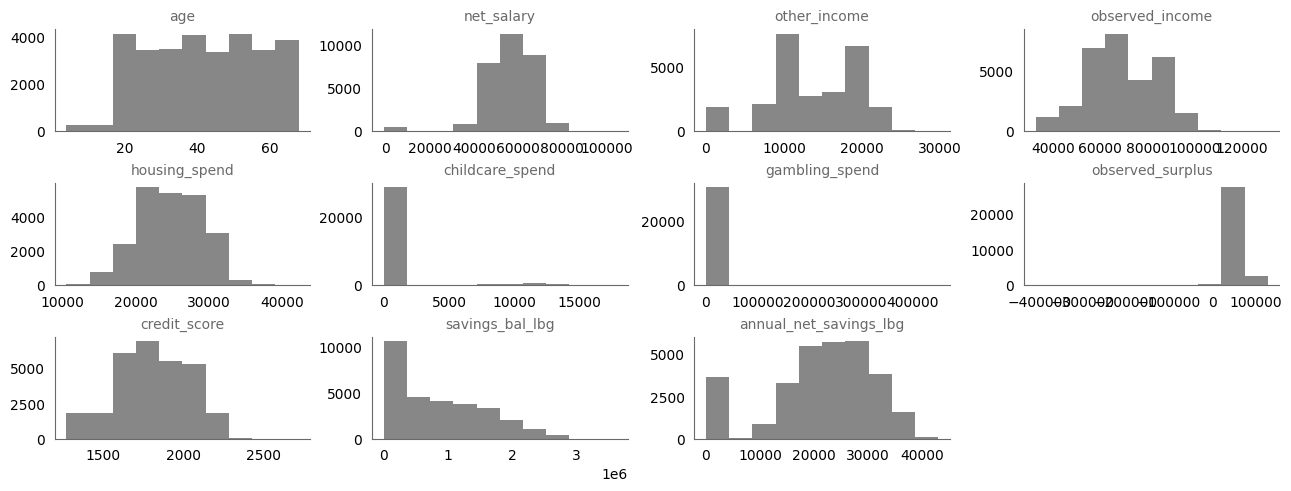

In [9]:
fig, axes = plt.subplots(
    nrows=3, ncols=4, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in raw_df.select_dtypes(include=['number']).columns:
    axes[i].hist(raw_df[col], color='dimgray', alpha=0.8, label='')
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[11])

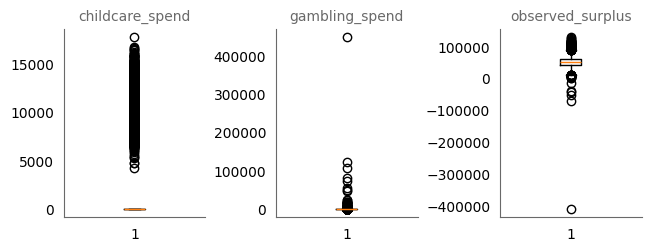

In [10]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, constrained_layout=True, figsize=(6.4, 4.8/2)
)
i = 0
axes = axes.flatten()
for col in ['childcare_spend', 'gambling_spend', 'observed_surplus']:
    axes[i].boxplot(raw_df[col])
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

In [11]:
for col in ['childcare_spend', 'gambling_spend']:
    print(
        f"Proportion of zeros in {col}: {raw_df.loc[raw_df[col] == 0, col].count()/len(raw_df.index)}"
    )

Proportion of zeros in childcare_spend: 0.9459825111367761
Proportion of zeros in gambling_spend: 0.9077379970301931


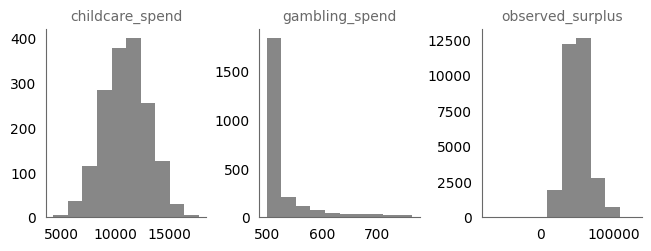

In [12]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, constrained_layout=True, figsize=(6.4, 4.8/2)
)

# Histogram for childcare_spend (excluding zeros)
axes[0].hist(raw_df.loc[raw_df['childcare_spend'] != 0,
             'childcare_spend'], color='dimgray', alpha=0.8, label=''
            )

# Histogram for gambling_spend (excluding zeros & outliers)
percentile_lower = np.percentile(raw_df['gambling_spend'], 91)
percentile_upper = np.percentile(raw_df['gambling_spend'], 99)
filter_condition = (raw_df['gambling_spend'] >= percentile_lower) & (
    raw_df['gambling_spend'] <= percentile_upper
)
axes[1].hist(raw_df.loc[filter_condition, 'gambling_spend'],
             color='dimgray', alpha=0.8, label=''
            )

# Histogram for observed_surplus (excluding zeros & max value)
axes[2].hist(raw_df.loc[raw_df['observed_surplus'] != raw_df['observed_surplus'].min(
), 'observed_surplus'], color='dimgray', alpha=0.8, label=''
            )

axes[0].set_title('childcare_spend', fontsize=10, color='dimgray')
axes[1].set_title('gambling_spend', fontsize=10, color='dimgray')
axes[2].set_title('observed_surplus', fontsize=10, color='dimgray')
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

**2) Categorical variables**

* No duplicate values are present in cust_unique_id.

* The distributions of gender, ethnicity_group and geo_region are imbalanced.

* One of the gender categories is called '999'. The meaning is unclear.

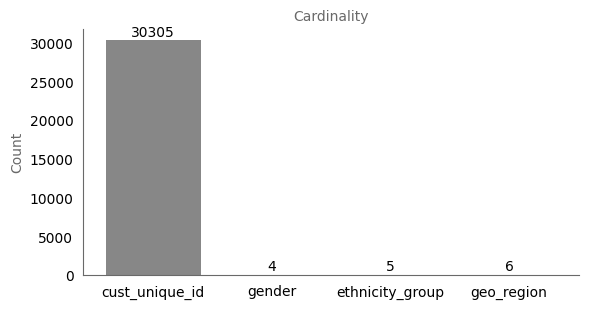

In [13]:
# Cardinality
fig, axes = plt.subplots(figsize=(6.4, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

object_nunique = raw_df.select_dtypes(include=['object', 'category']).nunique()
bars = axes.bar(object_nunique.index, object_nunique.values,
                color='dimgray', alpha=0.8
               )
axes.bar_label(bars, padding=1)
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.set_title('Cardinality', fontsize=10, color='dimgray');

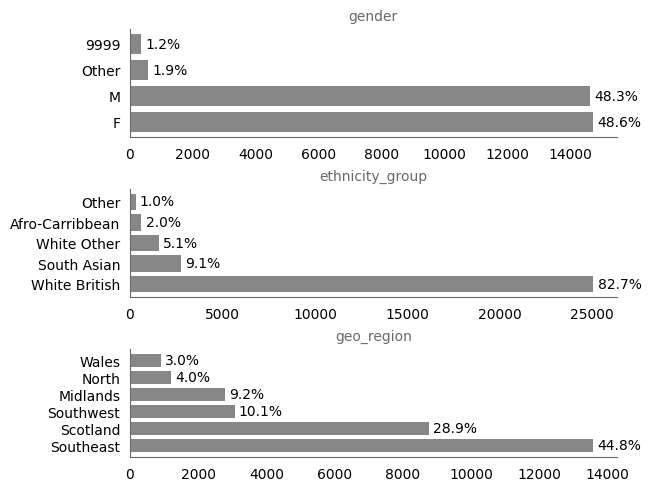

In [14]:
# Frequency plots
fig, axes = plt.subplots(
    nrows=3, ncols=1, constrained_layout=True, figsize=(6.4, 4.8)
)
i = 0
for col in ['gender', 'ethnicity_group', 'geo_region']:
    counts = raw_df[col].value_counts()
    percs = raw_df[col].value_counts(normalize=True)
    rects = axes[i].barh(counts.index, counts.values,
                         color='dimgray', alpha=0.8)
    axes[i].bar_label(rects, labels=[str(round(x*100, 1)) +
                      '%' for x in percs.values], padding=3)
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

### Missing values

* Missing values are present in the other_income (14.0%), housing_spend (24.3%) and credit_score (3.5%) columns.

* A total of 1,362 rows contain more than one missing value.

* A nullity correlation matrix indicates missing values are not correlated with missing values in other columns.

    Note: Methodology explained [here](https://stats.stackexchange.com/questions/491635/interpreting-a-nullity-correlation-matrix)

* A random forest is used to predict the occurrence of missing values. This was chosen as it can capture nonlinear relationships and requires no prior feature selection, feature scaling or removal of outliers. In order to address the class imbalance, the Random Forest was coupled with SMOTE.

* Random forests are trained to predict the presence of a missing value using observed values in other features. The optimal models for other_income and housing_spend display superior precision and recall compared to a no-skill classifier. This suggests these missing values are not missing completely at random. No meaningful performance was achieved for credit score. These missing values may therefore be missing at random.

    Note: All models used a binary indicator variable, which flags whether an observation is missing or not, as target. SMOTE was conducted on training data to balance the distribution of instances with/without a missing value.

#### Background

**1) Nullity correlation matrix**

* The missingno package computes the correlation matrix using the [phi coefficient](https://en.wikipedia.org/wiki/Phi_coefficient#:~:text=A%20Pearson%20correlation%20coefficient%20estimated,falls%20along%20the%20diagonal%20cells) $\phi$

* $\phi$ is equivalent to the Pearson correlation coefficient for two binary variables

* Calculated using contingency table

* $\phi \in [-1, +1]$

    $\phi=1$: A perfect positive association (both variables are always 1 together or always 0 together)

    $\phi=-1$ A perfect negative association (one variable is always 1 when the other is 0, and vice versa)

    $\phi=0$: No association.

--------------

**2) Random forest**

* Quality of split:

    * Measured using the *Gini coefficient* $I_G$:

        $I_G = \sum_{i=1}^Cp_i\bigl(1-p_i\bigr)$

        *Where $p_i$ is the probability of choosing an instance with class $i$ and $1-p_i$ is the probability of misclassifying it.*

    * Impurity is maximised when the set is evenly split among all classes. The max value depends on the number of classes:
  
        $C=2: max(I_G)=0.5$

        $C=1000: max(I_G)=0.999$

    * Impurity is $0$ when the set consists of only one class. 

* Hyperparameters:

    * Only $10$ constituent decision trees were used. This struck a balance between reducing variance and increasing computational time (during inference and optimisation).

    * The complexity of the model was tuned using the following hyperparameters:

        - Number of estimators
 
        - Max depth

-----------

**3) Synthetic Minority Over-sampling Technique (SMOTE)**

* Working with highly imbalanced data is problematic:

    - distorted performance metrics
  
    - poor generalisation as insufficient training leads to a poor decision boundary
 
* Default settings were used due to time constraints:
  
    - $\text{nearest neighbours} = 5$
 
    - The minority class was oversampled to a balanced distribution.

* Algorithm:

    - Select a member of the minority class $x_i$ at random

    - Identify its k-nearest neighbours

    - Randomly place a new observation between $x_i$ and each of its neighbours

        $x_{new} = x_i + \lambda\bigl(x_{zi}-x_i\bigr)$

        *Where $\lambda \in [0, 1]$*

---------------

**4) No-skill (random) classifier performance**

* Expected recall for the minority class:

    $Recall = \frac{TP}{TP + FN} = \frac{p\bigl(TP\bigr)}{p\bigl(TP\bigr) + p\bigl(FN\bigr)}$

    $Recall = \frac{pP}{pP + (1-p)P} = \frac{pP}{pP + P-pP} = p$

    *Where $P$ is the probability of an instance being class $1$, and  the random classifier outputs class $1$ with probability $p$.*

* Expected precision for the majority class:

    $Precision = \frac{TP}{TP + FP} = \frac{p\bigl(TP\bigr)}{p\bigl(TP\bigr) + p\bigl(FP\bigr)}$

    $Precision = \frac{pP}{pP + p(1-P)} = \frac{pP}{pP + p-pP} = P$

    *Where $P$ is the probability of an instance being class $1$, and  the random classifier outputs class $1$ with probability $p$.*

* In this instance:

  - $p=0.5$: A 'uniform' sampling strategy means the probability of outputting each class is the same.
 
  - $P$: The proportion of the relevant class.

#### Analyses

**Proportion of missing values**

In [15]:
# Identify columns with missing values
nan_summary = pd.concat(
    [raw_df.isnull().sum()[(raw_df.isnull().sum() > 1)],
     raw_df.isnull().sum()[(raw_df.isnull().sum() > 1)] / raw_df.shape[0]],
    axis=1, keys=['Count', '%']
)
display(nan_summary)

# Count rows with more than one missing value
rows_with_multiple_missing = raw_df[raw_df.isnull().sum(axis=1) > 1]
print(f"Number of rows with more than one missing value: {len(rows_with_multiple_missing)}")

,Count,%
other_income,4238,0.139845
housing_spend,7356,0.242732
credit_score,1050,0.034648


Number of rows with more than one missing value: 1362


**Nullity correlation matrix**

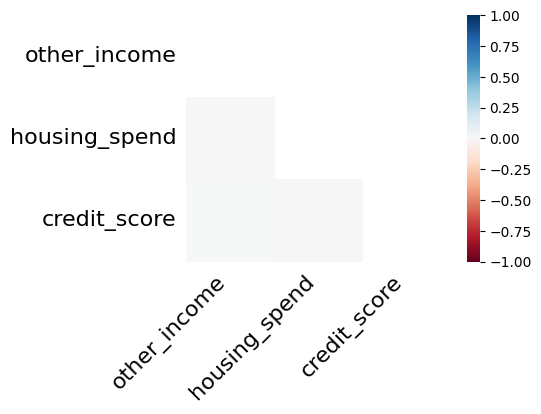

In [16]:
# Compute nullity correlation matrix
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6.4/1.5, 4.8/1.5))
msno.heatmap(raw_df, ax=axes);

**Predicting missing value occurrence**

* Performance is evaluated using a no-skill random classifier, precision & recall. 

    *Note: Accuracy cannot be used as the dummy classifier doesn't utilise SMOTE (i.e. classes are unbalanced).*

In [17]:
# Predict missing value using random forest
features_missing_values = ['other_income', 'housing_spend', 'credit_score']

for col in features_missing_values:
    # Encode missing values via indicator variables
    predicted_df = raw_df.copy()
    predicted_df[col + '_missing'] = predicted_df[col].isnull().astype(int)
    predicted_df = predicted_df.drop(columns=features_missing_values)

    # Train/test split
    y_col = col + '_missing'
    X_cols = [x for x in predicted_df.columns if x != col + '_missing' and x not in features_missing_values]
    X_train, X_test, y_train, y_test = train_test_split(
        predicted_df[X_cols], predicted_df[y_col], test_size=0.2, stratify=predicted_df[y_col], random_state=42
    )

    # Create a pipeline with a one hot encoder, SMOTE and a random forest
    categorical_features = ['gender', 'ethnicity_group', 'geo_region']
    preprocessor = ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)], 
        remainder='passthrough'
    )
    pipe = make_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier())
    
    # Define hyperparameters to tune
    param_grid = {
        'smote__sampling_strategy': [1.0],
        'randomforestclassifier__n_estimators': [10],
        'randomforestclassifier__max_depth': [None, 10, 20]}
       
    # Grid search
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', refit='f1')
    grid_search.fit(X_train, y_train)
    
    # Predict with the best model
    best_model = grid_search.best_estimator_
    predicted_values = best_model.predict(X_test)
    
    # Predict with a dummy model
    dummy_model = DummyClassifier(strategy='uniform')
    dummy_model.fit(X_train, y_train)
    dummy_predicted_values = dummy_model.predict(X_test)

    print(f'-----------------------------{col}-----------------------------')
    print('Best model: \n', classification_report(y_test, predicted_values))
    print('No-skill: \n', classification_report(y_test, dummy_predicted_values))

-----------------------------other_income-----------------------------
Best model: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5213
           1       0.98      0.87      0.92       848

    accuracy                           0.98      6061
   macro avg       0.98      0.93      0.95      6061
weighted avg       0.98      0.98      0.98      6061

No-skill: 
               precision    recall  f1-score   support

           0       0.86      0.50      0.63      5213
           1       0.14      0.51      0.22       848

    accuracy                           0.50      6061
   macro avg       0.50      0.50      0.43      6061
weighted avg       0.76      0.50      0.57      6061

-----------------------------housing_spend-----------------------------
Best model: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4590
           1       0.99      0.97      0.98      1471


## Data cleansing

### Erroneous data

* All occurences of 'PROMO34' in the credit_score column were replaced with a missing value earlier.

* No duplicate rows are present.

* The meaning of the "999" gender category is unclear. Given the relatively large number of records with this value, they will be left the same.

In [18]:
raw_df[raw_df.duplicated()]

,cust_unique_id,age,gender,ethnicity_group,geo_region,net_salary,other_income,observed_income,housing_spend,childcare_spend,gambling_spend,observed_surplus,credit_score,savings_bal_lbg,annual_net_savings_lbg


In [19]:
gender_breakdown = pd.concat([raw_df['gender'].value_counts(),
                              raw_df['gender'].value_counts(normalize=True)],
                             axis=1, keys=['Count', '%'])
gender_breakdown

,Count,%
gender,,
F,14742,0.486454
M,14623,0.482528
Other,580,0.019139
9999,360,0.011879


### Train/test split

* The raw data is divided using an 80/20 train/test split.

In [20]:
# Divide train/test data
X_cols = [x for x in raw_df.columns if x != 'annual_net_savings_lbg']
X_train, X_test, y_train, y_test = train_test_split(
    raw_df[X_cols], raw_df['annual_net_savings_lbg'], test_size=0.2, random_state=42
)
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(f'Train set dimensions: {train_df.shape}')
print(f'Test set dimensions: {test_df.shape}')

Train set dimensions: (24244, 15)
Test set dimensions: (6061, 15)


### Impute missing values

* The missing values in the other_income and housing_income columns are imputed via regression using a random forest. This decision was made as earlier work indicated the occurence of missing values is not completely at random and can be predicted with high accuracy using a random forest trained with observed values.

* A visual comparison of the other_income and housing_income distributions before and after imputation does reveal any substantial difference.

* The missing values in the credit_score column are dropped. Given these missing values appear to occur completely at random this is unlikely to introduce significant bias.

In [21]:
# Missing values in the training data
train_nan_summary = pd.concat([train_df.isnull().sum()[(train_df.isnull().sum() > 1)],
                               train_df.isnull().sum()[(train_df.isnull().sum() > 1)] / train_df.shape[0]],
                              axis=1, keys=['Count', '%']
                             )

# Missing values in the test data
test_nan_summary = pd.concat([test_df.isnull().sum()[(test_df.isnull().sum() > 1)],
                               test_df.isnull().sum()[(test_df.isnull().sum() > 1)] / test_df.shape[0]],
                              axis=1, keys=['Count', '%']
                             )
print(f'\n-----------------------------Missing values in training set-----------------------------')
display(train_nan_summary)
print(f'\n-----------------------------Missing values in test set-----------------------------')
display(test_nan_summary)


-----------------------------Missing values in training set-----------------------------


,Count,%
other_income,3387,0.139705
housing_spend,5892,0.243029
credit_score,851,0.035101



-----------------------------Missing values in test set-----------------------------


,Count,%
other_income,851,0.140406
housing_spend,1464,0.241544
credit_score,199,0.032833


In [22]:
# Create copies of train/test set for data cleansing
clean_train_df = train_df.copy(deep=True)
clean_test_df = test_df.copy(deep=True)

In [23]:
# Impute missing values in training data
features_missing_values = ['other_income', 'housing_spend', 'credit_score']

for col in ['other_income', 'housing_spend']:
    # Drop other features missing values in the training data
    temporary_train_df = clean_train_df.drop(
        columns=[x for x in features_missing_values if x != col]
    )

    # Split training data into records with and without missing values
    train_with_missing = temporary_train_df[temporary_train_df[col].isnull()].reset_index(drop=True)
    train_without_missing = temporary_train_df.dropna().reset_index(drop=True)

    # Prepare data for training the model
    y_train = train_without_missing[col]
    X_train = train_without_missing.drop(col, axis=1)
    X_test = train_with_missing.drop(col, axis=1)

    # Create pipeline
    categorical_features = ['gender', 'ethnicity_group', 'geo_region']
    preprocessor = ColumnTransformer(
        transformers=[(
            'onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
        remainder='passthrough'
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('rf_model', RandomForestRegressor(random_state=42))
    ])

    # Grid search
    param_grid = {
        'rf_model__n_estimators': [10],
        'rf_model__max_depth': [None, 10, 20]
    }
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)

    # Best configuration
    best_model = grid_search.best_estimator_
    print(col, grid_search.best_params_)

    # Predict missing values in training set
    y_pred = best_model.predict(X_test)

    # Fill missing values in training set
    Xy_pred = pd.concat([X_test, pd.Series(y_pred, name=col)], axis=1)
    clean_train_df = clean_train_df.merge(
        Xy_pred[['cust_unique_id', col]], how='left', on='cust_unique_id'
    )
    clean_train_df[col] = clean_train_df[col + '_x'].fillna(
        clean_train_df[col + '_y']
    )
    clean_train_df = clean_train_df.drop(
        columns=[col + '_x', col + '_y'])

    # Predict missing values in test set
    test_with_missing = clean_test_df[clean_test_df[col].isnull()].drop(columns=features_missing_values).reset_index(drop=True)
    test_y_pred = best_model.predict(test_with_missing)

    # Fill missing values in test set 
    test_Xy_pred = pd.concat(
        [test_with_missing, pd.Series(test_y_pred, name=col)], axis=1
    )
    clean_test_df = clean_test_df.merge(
        test_Xy_pred[['cust_unique_id', col]], how='left', on='cust_unique_id'
    )
    clean_test_df[col] = clean_test_df[col + '_x'].fillna(
        clean_test_df[col + '_y']
    )
    clean_test_df = clean_test_df.drop(
        columns=[col + '_x', col + '_y']
    )

other_income {'rf_model__max_depth': 20, 'rf_model__n_estimators': 10}
housing_spend {'rf_model__max_depth': None, 'rf_model__n_estimators': 10}


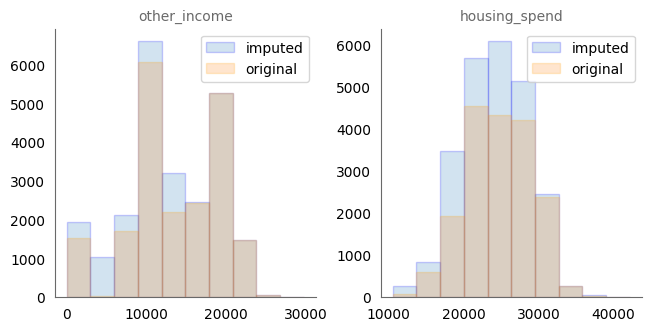

In [24]:
# Visualise training set distributions before & after imputation
fig, axes = plt.subplots(
    nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5)
)
i = 0
axes = axes.flatten()
for col in ['other_income', 'housing_spend']:
    axes[i].hist(
        clean_train_df[col], alpha=0.2, edgecolor='blue', label='imputed'
    )
    axes[i].hist(
        train_df[col], alpha=0.2, edgecolor='orange', label='original'
    )
    axes[i].set_title(
        col, fontsize=10, color='dimgray'
    )
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.legend(loc='best')

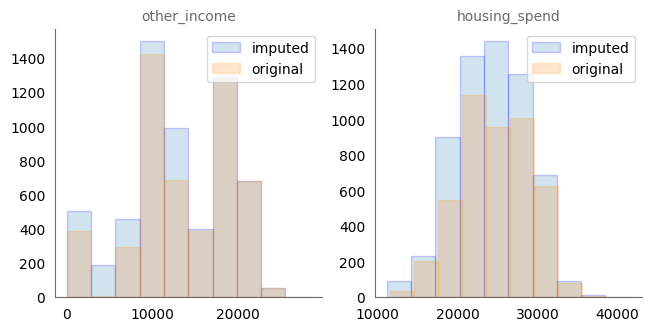

In [25]:
# Visualise test set distributions before & after imputation
fig, axes = plt.subplots(
    nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5)
)
i = 0
axes = axes.flatten()
for col in ['other_income', 'housing_spend']:
    axes[i].hist(
        clean_test_df[col], alpha=0.2, edgecolor='blue', label='imputed'
    )
    axes[i].hist(
        test_df[col], alpha=0.2, edgecolor='orange', label='original'
    )
    axes[i].set_title(
        col, fontsize=10, color='dimgray'
    )
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.legend(loc='best')

In [26]:
# Drop missing values in the credit_score column
print(f"Training set shape before imputation:{clean_train_df.shape}")
print(f"Test set shape before imputation:{clean_test_df.shape}")

clean_train_df = clean_train_df[clean_train_df['credit_score'].isna(
) == False].reset_index(drop=True)
clean_test_df = clean_test_df[clean_test_df['credit_score'].isna(
) == False].reset_index(drop=True)

print(f"Training set shape after imputation:{clean_train_df.shape}")
print(f"Test set shape after imputation:{clean_test_df.shape}")

Training set shape before imputation:(24244, 15)
Test set shape before imputation:(6061, 15)
Training set shape after imputation:(23393, 15)
Test set shape after imputation:(5862, 15)


### Outliers
* The outlier present in the observed_surplus column is dropped as it was roughly 29 standard deviations lower than the mean. This is highly unlikely.

    Note: A normal quantile-quantile plot is used to assess normality of the observed_surplus column. It is roughly normal but does display a negative skew.

* The outlier in the gambling_spend column is left untouched. Instead its influence on later modelling will assessed. If its presence significantly affects outcomes, it may be excluded.

    Note: The distribution of gambling_spend is clearly not normal. The outlier is therefore not excluded on the basis of its z score.

#### Background

**1) Quantile–quantile plot**

* A graphical method for comparing two probability distributions by plotting their quantiles against each other.

* In this instance, we are comparing the 'observed_surplus' when standardised to the standard normal distribution.

    * Blue: Ordered observed values vs corresponding z-scores
 
        $z_{actual} = \frac{x_{actual}-\bar{x}}{s}$

    * Red: Theoretical values vs theoretical z-scores
 
        $x_{theory} = z_{theory}s + \bar{x}$

        Note: A z score of 0 corresponds to the 50th percentile

Additional notes:

* Theoretical quantiles (e.g. percentiles) may be plotted across the x-axis.

* For a standard normal distribution, percentiles can be calculated using the $68-95-99.7$ rule:

  <img src="./figures/percentiles_zscores.png" align="centre" width="350" />

* Note a q-q plot can be used to compare any two distributions. For non-normal distributions, the theoretical value of a random variable $X$ for a given percentile can be calculated using the inverse of its CDF:

    $F_X(x)=P(X\leq x)$

    $F^{-1}(p)=x$

    $F^{-1}(0.5)=x_{median}$
  
    *Where $F_X(x)$ is the CDF and its inverse $F^-1(p)$ is the quantile function.*

#### Analyses

* The distribution is approximately normal but does exhibit a negative skew.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Sample Mean (excluding minimum value): 51267.07948272914
Sample Standard Deviation (excluding minimum value): 15848.924804039245
Outlier z-score: -29.017904695056583


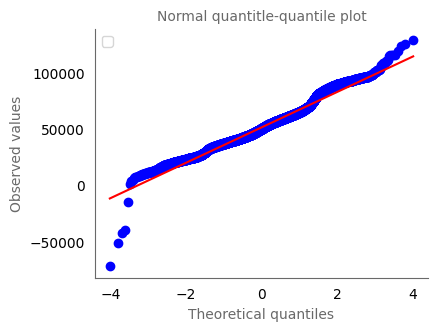

In [30]:
# Find and exclude the outlier
outlier = raw_df['observed_surplus'].min()
surplus_without_outlier = clean_train_df.loc[clean_train_df['observed_surplus']
                                                 != outlier, 'observed_surplus']

# Calculate the sample standard deviation for the modified data
sample_std_dev= np.std(surplus_without_outlier, ddof=1)
sample_mean= surplus_without_outlier.mean()
outlier_zscore= (outlier - sample_mean)/sample_std_dev
print(f"Sample Mean (excluding minimum value): {sample_mean}")
print(f"Sample Standard Deviation (excluding minimum value): {sample_std_dev}")
print(f"Outlier z-score: {outlier_zscore}")

# Visualise q-q plot for the modified data
fig, axes= plt.subplots(
    nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5)
)
probplot(surplus_without_outlier, dist="norm", plot=axes)
axes.set_title('Normal quantitle-quantile plot', fontsize=10, color='dimgray')
axes.set_ylabel('Observed values', fontsize=10, color='dimgray')
axes.set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

In [28]:
# Remove outlier
print(f"Training set shape before outlier removal:{clean_train_df.shape}")
clean_train_df = clean_train_df[clean_train_df['observed_surplus'] != outlier]
print(f"Training set shape after outlier removal:{clean_train_df.shape}")

Training set shape before outlier removal:(23393, 15)
Training set shape after outlier removal:(23392, 15)


# Save data

In [29]:
clean_train_df.to_csv('../data/cleaned/clean_train.csv', index=False)
clean_test_df.to_csv('../data/cleaned/clean_test.csv', index=False)